In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler, label_binarize
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb

# Load the data
data = pd.read_csv('EVSE-B-PowerCombined_Multi.csv')
data.head(5)

# Assuming 'Scenario' is the column representing the class labels
X = data.drop('Attack-Group', axis=1)
y = data['Attack-Group']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# Define and fit KNN model for feature extraction
knn = KNeighborsClassifier()
knn.fit(X_train, y_train)
knn_train_features = knn.predict_proba(X_train)
knn_test_features = knn.predict_proba(X_test)

# Define and fit SVM model for feature extraction
svm = SVC(probability=True)
svm.fit(X_train, y_train)
svm_train_features = svm.predict_proba(X_train)
svm_test_features = svm.predict_proba(X_test)

# Combine KNN and SVM features
combined_train_features = np.hstack((knn_train_features, svm_train_features))
combined_test_features = np.hstack((knn_test_features, svm_test_features))

# Apply PCA on combined features
pca = PCA(n_components=0.95)  # Retain 95% variance
combined_train_pca = pca.fit_transform(combined_train_features)
combined_test_pca = pca.transform(combined_test_features)

# XGBoost for classification
xgb_clf = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')
xgb_clf.fit(combined_train_pca, y_train)
y_pred_xgb = xgb_clf.predict(combined_test_pca)
y_proba_xgb = xgb_clf.predict_proba(combined_test_pca)[:, 1]

# Individual classifiers
# KNN
knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_train)
y_pred_knn = knn_clf.predict(X_test)
y_proba_knn = knn_clf.predict_proba(X_test)[:, 1]

# SVM
svm_clf = SVC(probability=True)
svm_clf.fit(X_train, y_train)
y_pred_svm = svm_clf.predict(X_test)
y_proba_svm = svm_clf.predict_proba(X_test)[:, 1]

# Random Forest
rf_clf = RandomForestClassifier()
rf_clf.fit(X_train, y_train)
y_pred_rf = rf_clf.predict(X_test)
y_proba_rf = rf_clf.predict_proba(X_test)[:, 1]

# Decision Tree
dt_clf = DecisionTreeClassifier()
dt_clf.fit(X_train, y_train)
y_pred_dt = dt_clf.predict(X_test)
y_proba_dt = dt_clf.predict_proba(X_test)[:, 1]

# Cross-validation evaluation function
def cross_val_evaluate(model, X, y, cv_folds):
    scores = cross_val_score(model, X, y, cv=cv_folds, scoring='accuracy')
    print(f'Cross-Validation Accuracy for {cv_folds} folds: {np.mean(scores):.2f} ± {np.std(scores):.2f}')

# Cross-validation evaluation for each model with 5, 7, and 10 folds
print("\nCross-Validation Results:")
for cv_folds in [5, 7, 10]:
    print(f"\nKNN (CV={cv_folds}):")
    cross_val_evaluate(knn_clf, X, y, cv_folds)
    
    print(f"\nSVM (CV={cv_folds}):")
    cross_val_evaluate(svm_clf, X, y, cv_folds)
    
    print(f"\nRandom Forest (CV={cv_folds}):")
    cross_val_evaluate(rf_clf, X, y, cv_folds)
    
    print(f"\nDecision Tree (CV={cv_folds}):")
    cross_val_evaluate(dt_clf, X, y, cv_folds)
    
    print(f"\nCombined KNN + SVM Features + XGBoost (CV={cv_folds}):")
    cross_val_evaluate(xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss'), combined_train_pca, y_train, cv_folds)

# Function to print results
def print_results(y_test, y_pred, y_proba, title):
    # Test accuracy
    accuracy = np.mean(y_test == y_pred)
    print(f'{title} Test Accuracy: {accuracy:.2f}')
    
    # Classification report
    print(f'{title} Classification Report')
    print(classification_report(y_test, y_pred))

    # ROC curve
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    roc_auc = auc(fpr, tpr)
    print(f'{title} AUC: {roc_auc:.2f}')

# Print results for combined KNN + SVM features + XGBoost
print_results(y_test, y_pred_xgb, y_proba_xgb, "Combined KNN + SVM Features + XGBoost")

# Print results for KNN
print_results(y_test, y_pred_knn, y_proba_knn, "KNN")

# Print results for SVM
print_results(y_test, y_pred_svm, y_proba_svm, "SVM")

# Print results for Random Forest
print_results(y_test, y_pred_rf, y_proba_rf, "Random Forest")

# Print results for Decision Tree
print_results(y_test, y_pred_dt, y_proba_dt, "Decision Tree")


Cross-Validation Results:

KNN (CV=5):
Cross-Validation Accuracy for 5 folds: 0.75 ± 0.03

SVM (CV=5):
Cross-Validation Accuracy for 5 folds: 0.81 ± 0.13

Random Forest (CV=5):
Cross-Validation Accuracy for 5 folds: 0.77 ± 0.08

Decision Tree (CV=5):
Cross-Validation Accuracy for 5 folds: 0.76 ± 0.08

Combined KNN + SVM Features + XGBoost (CV=5):
Cross-Validation Accuracy for 5 folds: 0.83 ± 0.01

KNN (CV=7):
Cross-Validation Accuracy for 7 folds: 0.75 ± 0.03

SVM (CV=7):
Cross-Validation Accuracy for 7 folds: 0.81 ± 0.13

Random Forest (CV=7):
Cross-Validation Accuracy for 7 folds: 0.78 ± 0.08

Decision Tree (CV=7):
Cross-Validation Accuracy for 7 folds: 0.77 ± 0.08

Combined KNN + SVM Features + XGBoost (CV=7):
Cross-Validation Accuracy for 7 folds: 0.83 ± 0.01

KNN (CV=10):
Cross-Validation Accuracy for 10 folds: 0.75 ± 0.04

SVM (CV=10):
Cross-Validation Accuracy for 10 folds: 0.81 ± 0.13

Random Forest (CV=10):
Cross-Validation Accuracy for 10 folds: 0.78 ± 0.09

Decision Tree (C

ValueError: multiclass format is not supported

In [2]:
from sklearn.metrics import classification_report

# Function to print classification report
def print_classification_report(y_test, y_pred, title="Model"):
    print(f'{title} Classification Report')
    print(classification_report(y_test, y_pred))

# Example usage
print_classification_report(y_test, y_pred_xgb, title="Combined KNN + SVM Features + XGBoost")
print_classification_report(y_test, y_pred_knn, title="KNN")
print_classification_report(y_test, y_pred_svm, title="SVM")
print_classification_report(y_test, y_pred_rf, title="Random Forest")
print_classification_report(y_test, y_pred_dt, title="Decision Tree")

Combined KNN + SVM Features + XGBoost Classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2995
           1       0.72      0.52      0.60      7067
           2       1.00      1.00      1.00      6439
           3       0.60      0.79      0.68      6559

    accuracy                           0.79     23060
   macro avg       0.83      0.83      0.82     23060
weighted avg       0.80      0.79      0.79     23060

KNN Classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2995
           1       0.68      0.57      0.62      7067
           2       1.00      1.00      1.00      6439
           3       0.60      0.71      0.65      6559

    accuracy                           0.79     23060
   macro avg       0.82      0.82      0.82     23060
weighted avg       0.79      0.79      0.78     23060

SVM Classification Report
              prec

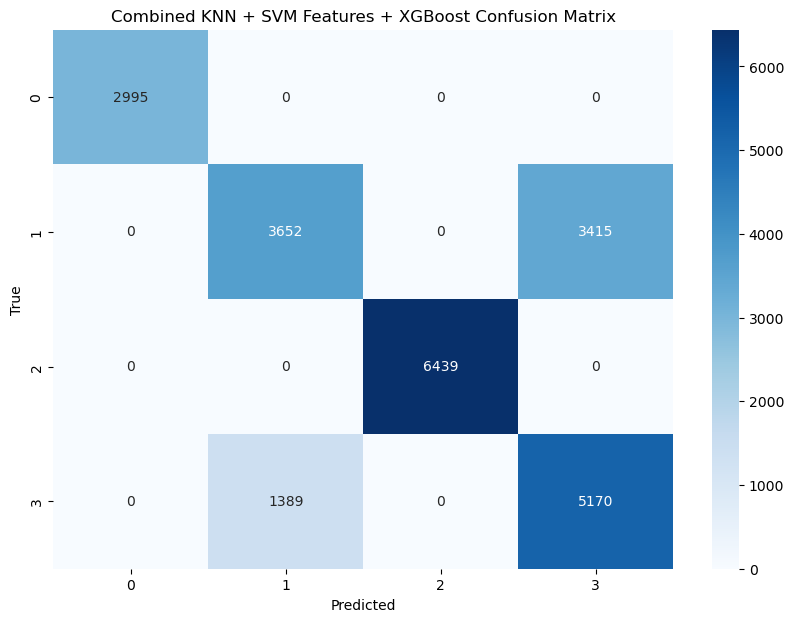

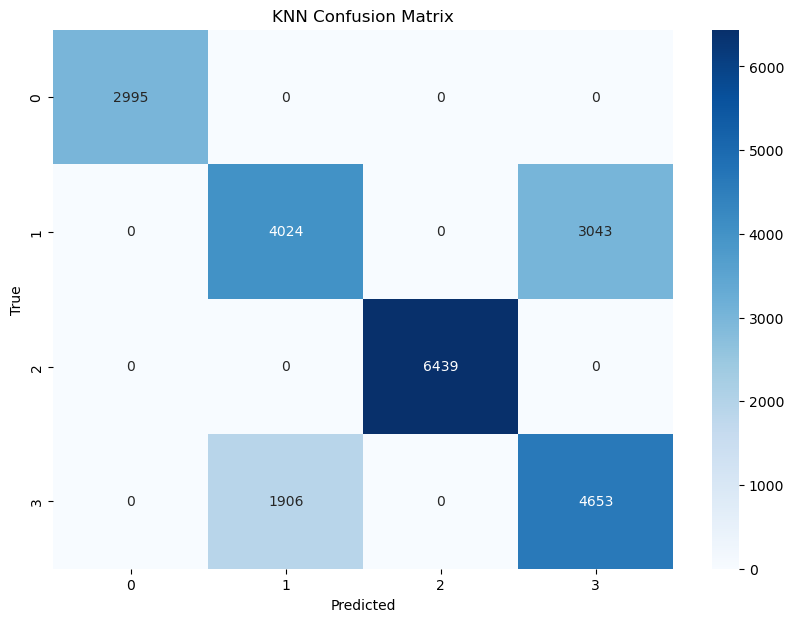

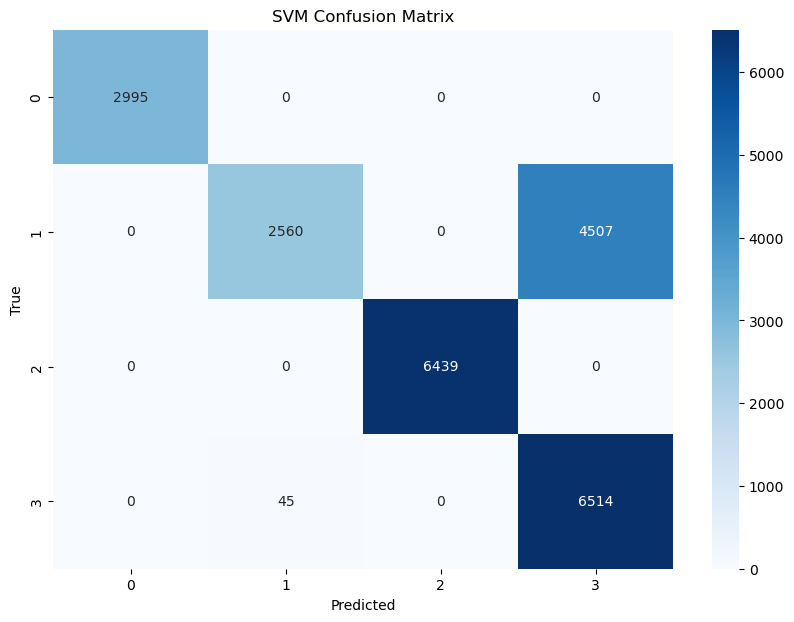

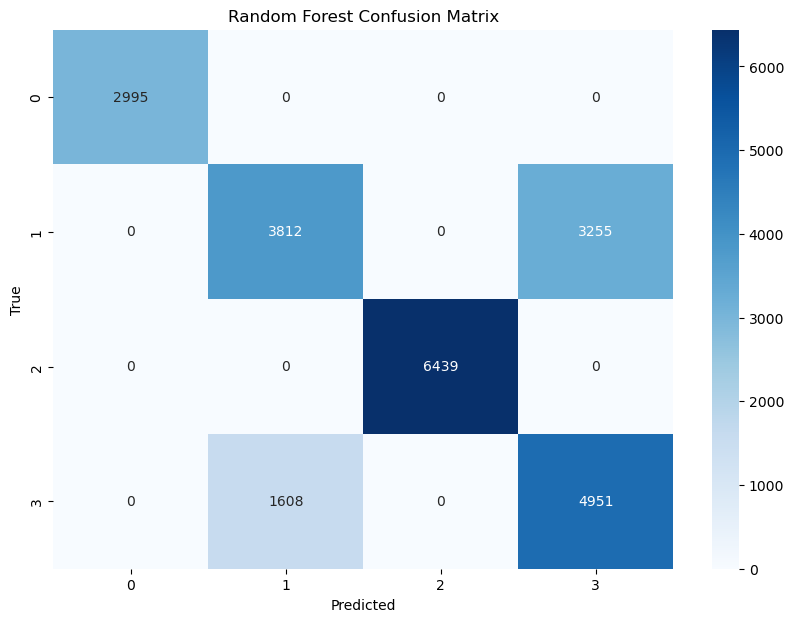

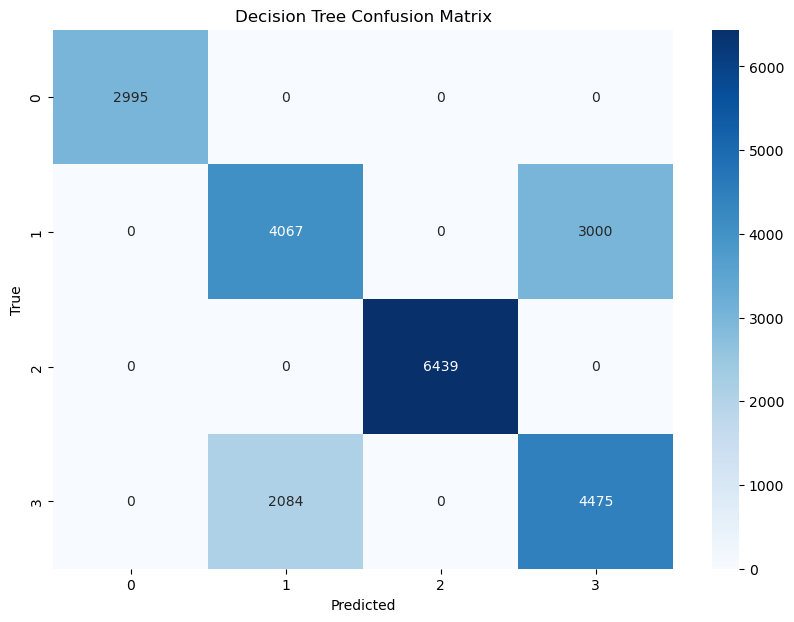

In [3]:
from sklearn.metrics import confusion_matrix

# Function to print confusion matrix
def print_confusion_matrix(y_test, y_pred, title="Model"):
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'{title} Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

# Example usage
print_confusion_matrix(y_test, y_pred_xgb, title="Combined KNN + SVM Features + XGBoost")
print_confusion_matrix(y_test, y_pred_knn, title="KNN")
print_confusion_matrix(y_test, y_pred_svm, title="SVM")
print_confusion_matrix(y_test, y_pred_rf, title="Random Forest")
print_confusion_matrix(y_test, y_pred_dt, title="Decision Tree")

KNN Classification Report for 5-Fold Cross-Validation
Precision: 0.79
Recall: 0.78
F1-Score: 0.78


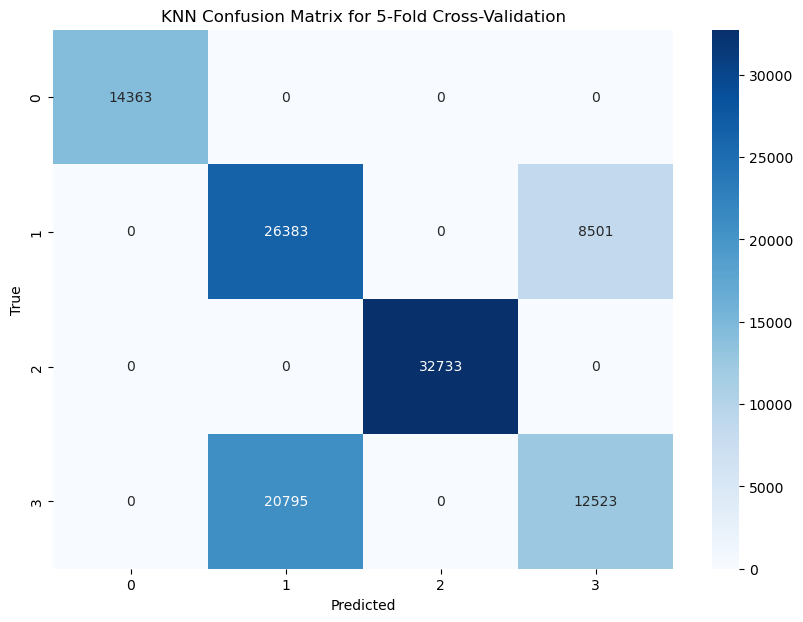

KNN Classification Report for 7-Fold Cross-Validation
Precision: 0.79
Recall: 0.78
F1-Score: 0.78


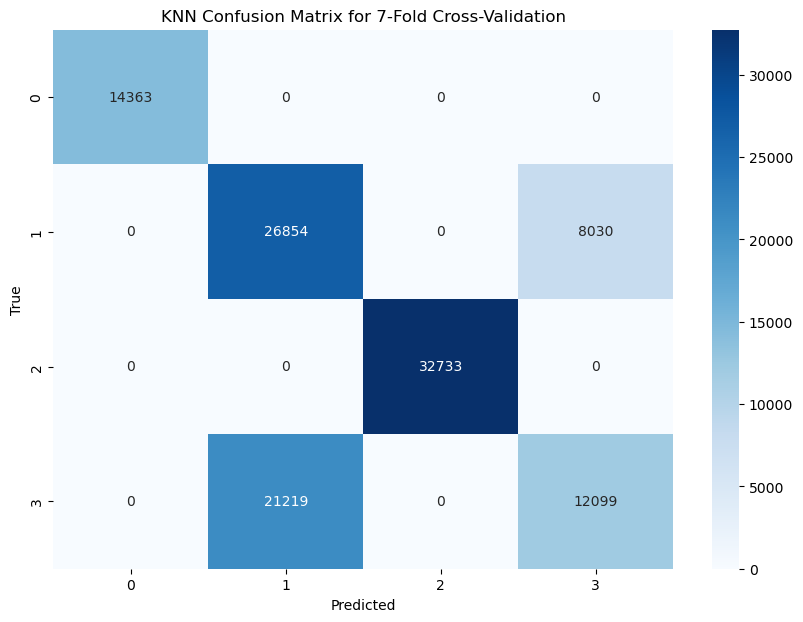

KNN Classification Report for 10-Fold Cross-Validation
Precision: 0.79
Recall: 0.78
F1-Score: 0.78


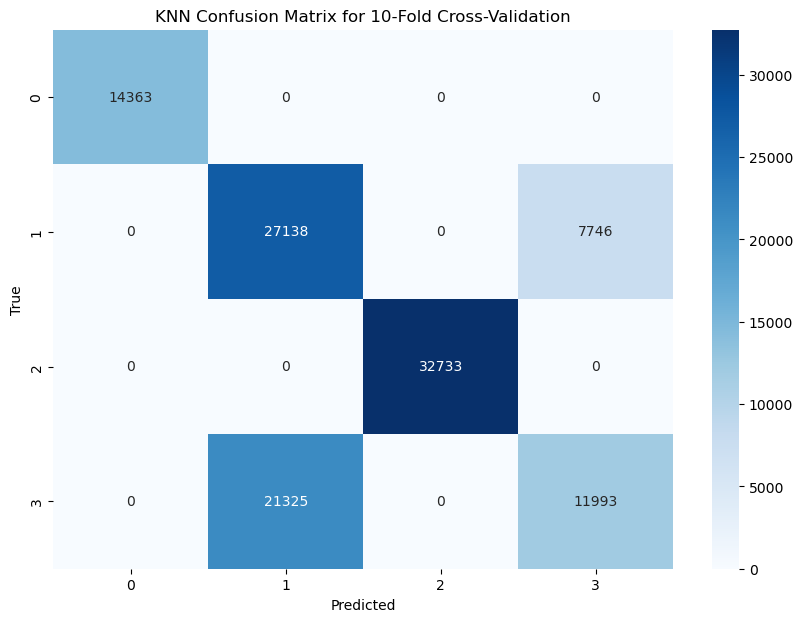

SVM Classification Report for 5-Fold Cross-Validation
Precision: 0.89
Recall: 0.84
F1-Score: 0.82


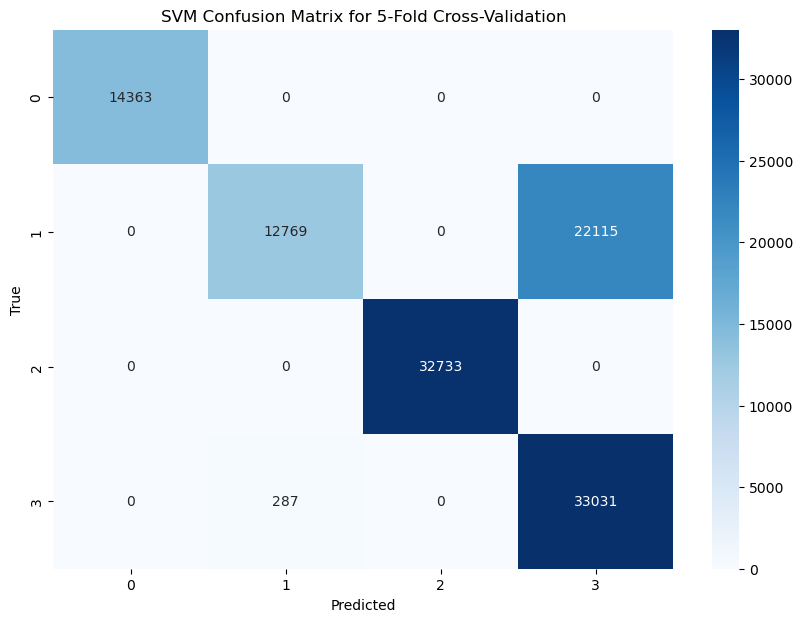

SVM Classification Report for 7-Fold Cross-Validation
Precision: 0.89
Recall: 0.84
F1-Score: 0.82


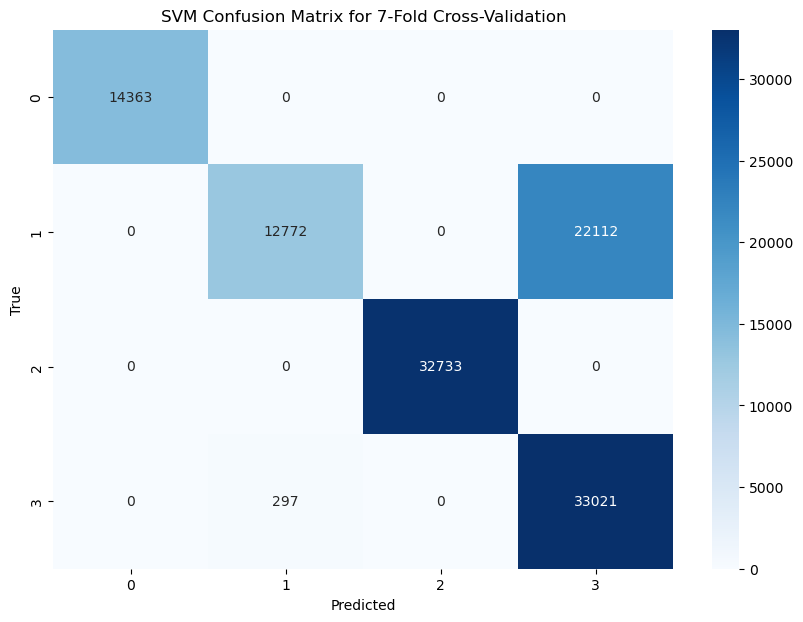

SVM Classification Report for 10-Fold Cross-Validation
Precision: 0.89
Recall: 0.84
F1-Score: 0.82


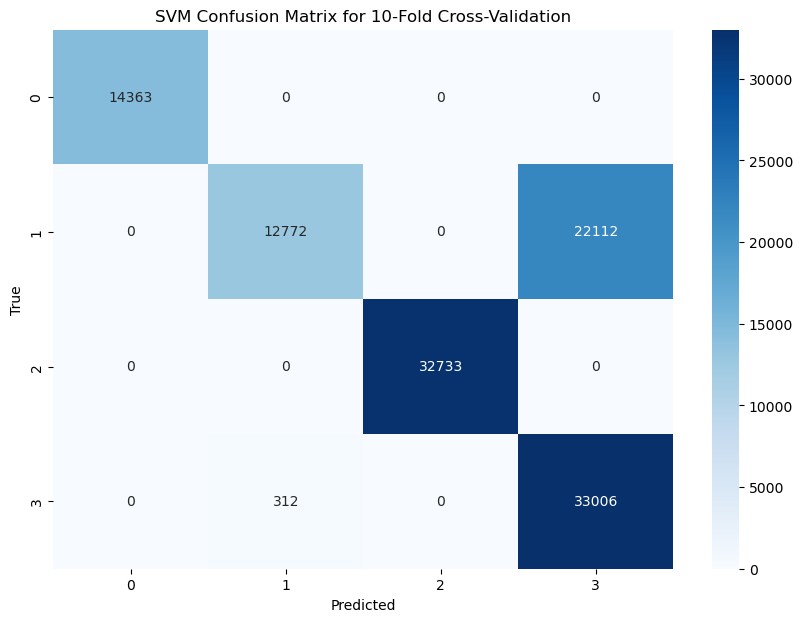

Random Forest Classification Report for 5-Fold Cross-Validation
Precision: 0.81
Recall: 0.81
F1-Score: 0.81


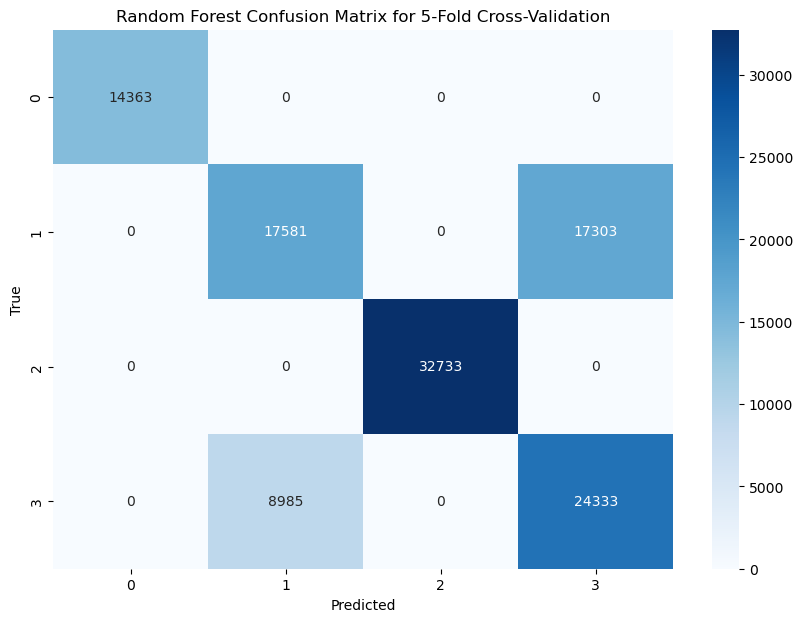

Random Forest Classification Report for 7-Fold Cross-Validation
Precision: 0.82
Recall: 0.81
F1-Score: 0.81


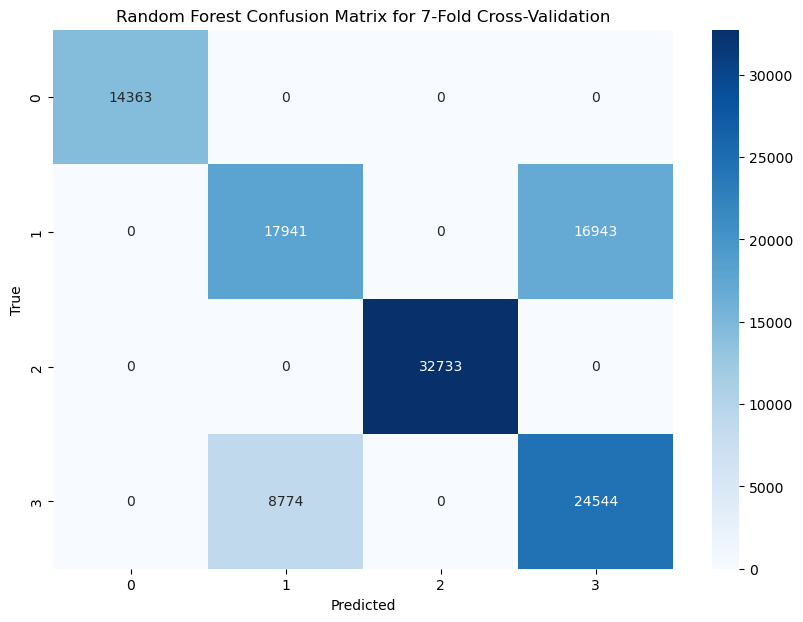

Random Forest Classification Report for 10-Fold Cross-Validation
Precision: 0.82
Recall: 0.82
F1-Score: 0.81


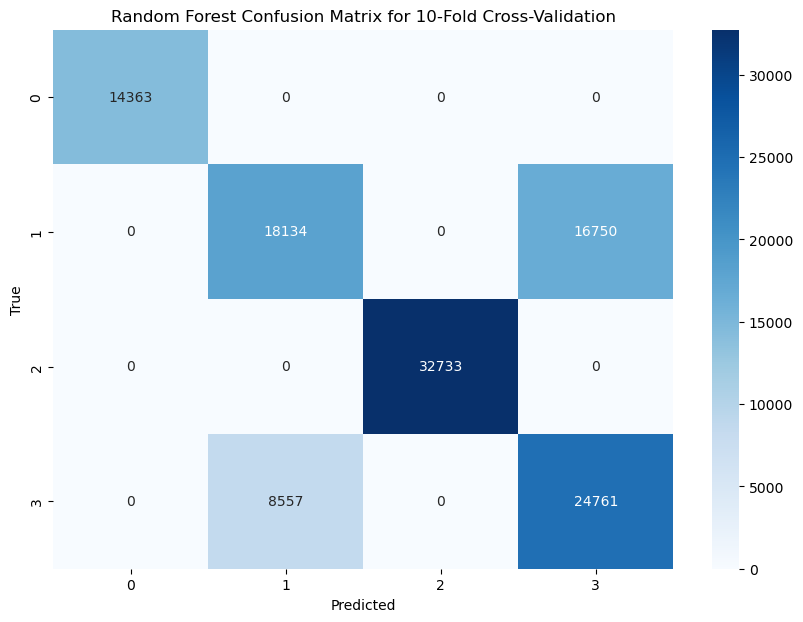

Decision Tree Classification Report for 5-Fold Cross-Validation
Precision: 0.80
Recall: 0.80
F1-Score: 0.80


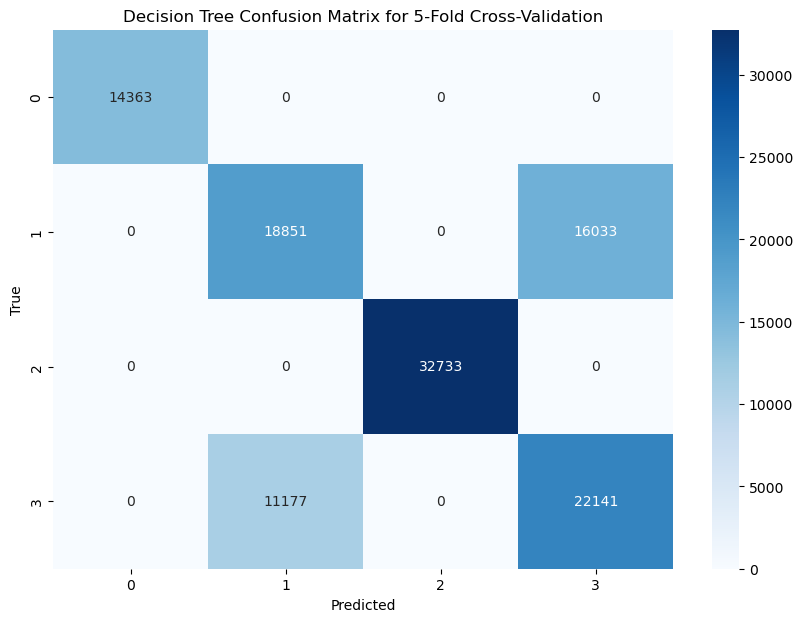

Decision Tree Classification Report for 7-Fold Cross-Validation
Precision: 0.81
Recall: 0.81
F1-Score: 0.80


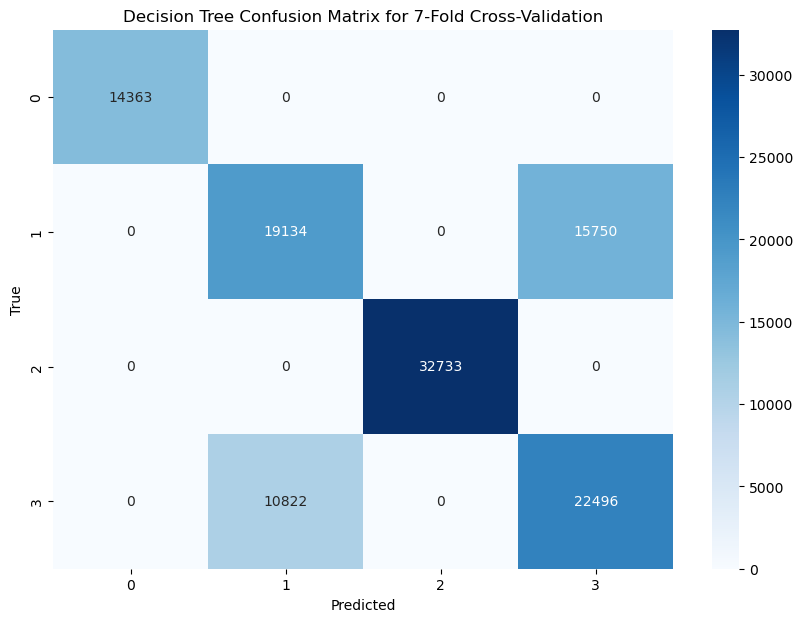

Decision Tree Classification Report for 10-Fold Cross-Validation
Precision: 0.81
Recall: 0.81
F1-Score: 0.81


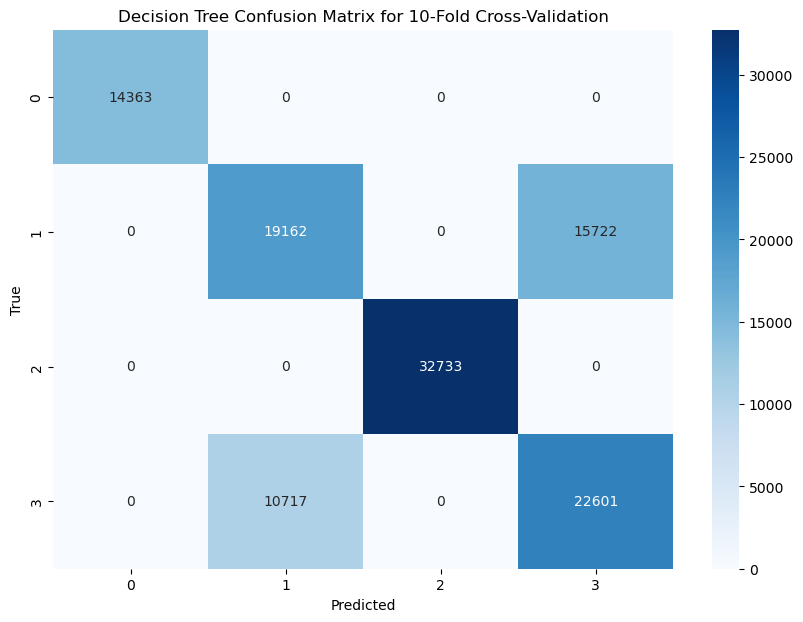

Combined KNN + SVM Features + XGBoost Classification Report for 5-Fold Cross-Validation
Precision: 0.84
Recall: 0.82
F1-Score: 0.81


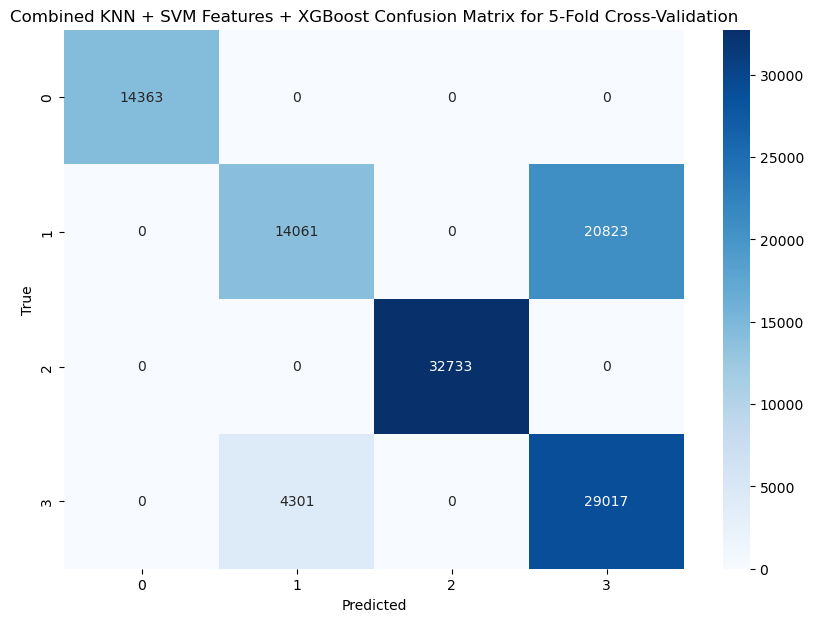

Combined KNN + SVM Features + XGBoost Classification Report for 7-Fold Cross-Validation
Precision: 0.85
Recall: 0.82
F1-Score: 0.81


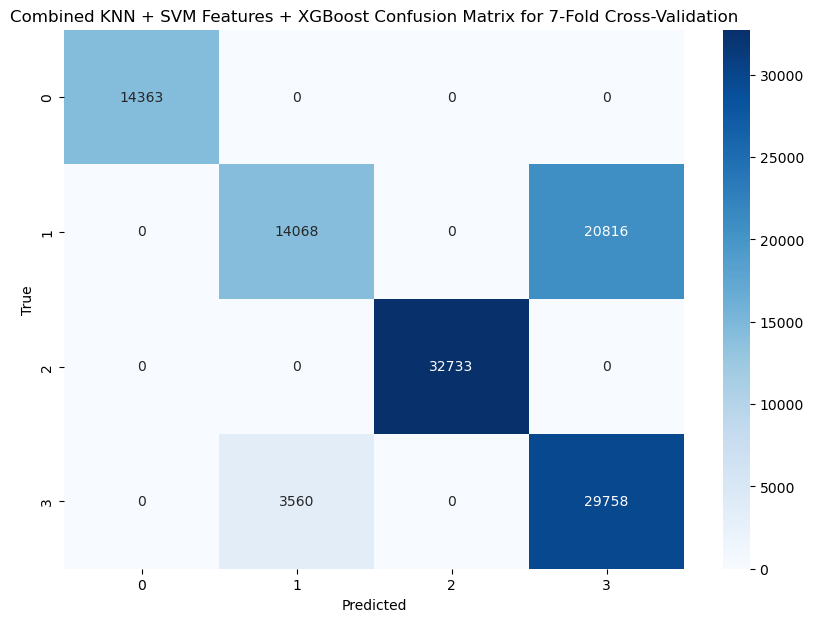

Combined KNN + SVM Features + XGBoost Classification Report for 10-Fold Cross-Validation
Precision: 0.86
Recall: 0.83
F1-Score: 0.82


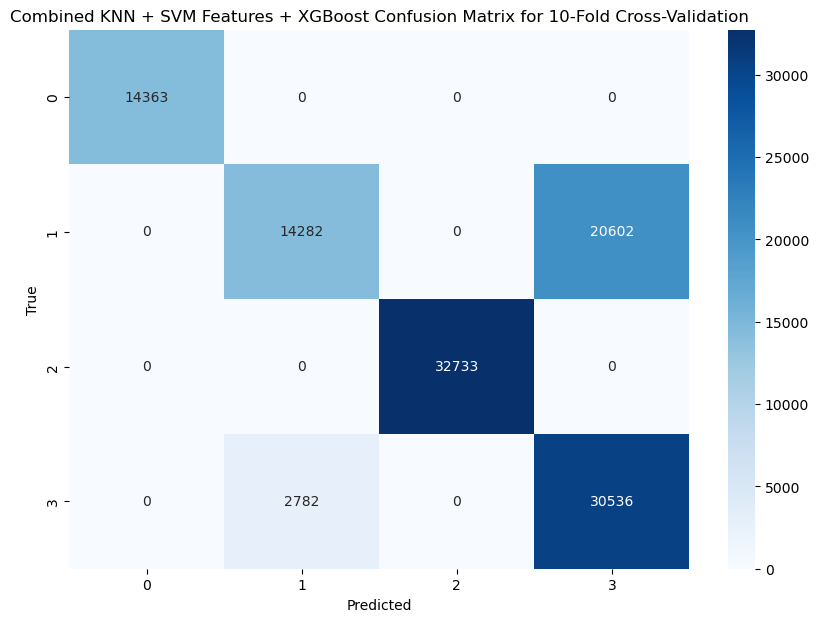

In [4]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Function to print average classification report for cross-validation
def cross_val_classification_report(model, X, y, cv_folds, title="Model"):
    y_pred = cross_val_predict(model, X, y, cv=cv_folds)
    report = classification_report(y, y_pred, output_dict=True)
    avg_report = {
        "precision": report['macro avg']['precision'],
        "recall": report['macro avg']['recall'],
        "f1-score": report['macro avg']['f1-score']
    }
    print(f'{title} Classification Report for {cv_folds}-Fold Cross-Validation')
    print(f"Precision: {avg_report['precision']:.2f}")
    print(f"Recall: {avg_report['recall']:.2f}")
    print(f"F1-Score: {avg_report['f1-score']:.2f}")

# Function to print average confusion matrix for cross-validation
def cross_val_confusion_matrix(model, X, y, cv_folds, title="Model"):
    y_pred = cross_val_predict(model, X, y, cv=cv_folds)
    cm = confusion_matrix(y, y_pred)
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'{title} Confusion Matrix for {cv_folds}-Fold Cross-Validation')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

# Example models
models = {
    "KNN": knn_clf,
    "SVM": svm_clf,
    "Random Forest": rf_clf,
    "Decision Tree": dt_clf,
    "Combined KNN + SVM Features + XGBoost": xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')
}

# Evaluate each model with 5, 7, and 10 folds
for model_name, model in models.items():
    for cv_folds in [5, 7, 10]:
        cross_val_classification_report(model, X, y, cv_folds, title=model_name)
        cross_val_confusion_matrix(model, X, y, cv_folds, title=model_name)